In [1]:
import os
import ast

# preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import ML libraries
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Input, Lambda, Reshape, RepeatVector
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

# with inspiration from deeplearning.ai's 'Improvise a Jazz Solo' 
# https://www.coursera.org/learn/nlp-sequence-models

In [2]:
# set relative directory paths
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')
DATA_LOOKUPS_DIR = os.path.join(DATA_DIR, 'lookups')
DATA_RAW_DIR = os.path.join(DATA_DIR, 'raw')
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
DATA_TRAIN_DIR = os.path.join(DATA_PROCESSED_DIR, 'train')
DATA_TEST_DIR = os.path.join(DATA_PROCESSED_DIR, 'test')
key_chord_mapping = pd.read_csv(os.path.join(DATA_LOOKUPS_DIR, 'musical_key-triad_chord_mapping.csv'), index_col='Degree')

In [3]:
def filter_sections_by_length(df, t_l, t_h):
    '''
    keep sections from df whose lengths are in set [t_l, t_h] inclusive
    '''
    df['section_length'] = df.chords.apply(len)
    df = df[(df.section_length >= t_l) & (df.section_length <= t_h)]
    
    return df.drop(columns='section_length')


def remove_duplicates(df):
    '''
    remove duplicate entries for each song
    '''
    song_ids = df.id.unique()
    df_unique = pd.DataFrame()
    df.chords = df.chords.apply(str)
    for i in song_ids:
        sec = df[df.id == i].chords.unique()
        song_id_array = [i] * len(sec)
        data = {'song_id': song_id_array, 'chords': sec}
        df_unique = df_unique.append(pd.DataFrame(data))
    df_unique.chords = df_unique.chords.apply(ast.literal_eval)
    
    return df_unique


def extend_section_lengths(sections, L):
    '''
    extends chords in series to length, L
    sections, s, will be repeated and truncated at length l
    '''
    long_sections = []
    for s in sections:
        long_sec = []
        if len(s) == 0:
            continue
        while len(long_sec) < L:
            long_sec.extend(s)
        long_sections.append(long_sec[:L])
        
    return pd.Series(long_sections)

In [4]:
df = pd.read_csv(os.path.join(DATA_RAW_DIR, 'chords_by_section.csv'), index_col='Unnamed: 0')
df = df[['id', 'chords_numeric']]
df.chords_numeric = df.chords_numeric.apply(ast.literal_eval)
df.rename(columns={'chords_numeric': 'chords'}, inplace=True)

MIN_SECTION_LENGTH = 2
MAX_SECTION_LENGTH = 16
df = filter_sections_by_length(df, MIN_SECTION_LENGTH, MAX_SECTION_LENGTH)
df = remove_duplicates(df)

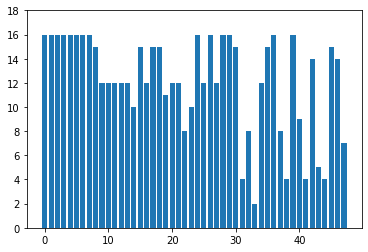

In [5]:
df['section_length'] = df.chords.apply(len)
plt.figure();
plt.ylim(ymax=max(df.section_length) + 2, ymin=min(df.section_length) - 2);
plt.bar(df.index, df.section_length);
df.drop(columns='section_length');

In [6]:
SECTION_LENGTH = 20
df.chords = extend_section_lengths(df.chords, SECTION_LENGTH)
df = df.reset_index().drop(columns='index')

shape_X = (len(df.chords), SECTION_LENGTH, 7)  # 7 choices for chord type
shape_Y = (SECTION_LENGTH, len(df.chords), 7)
X = np.zeros(shape_X)
Y = np.zeros(shape_Y)

def move_first_timestep_to_end(y):
    '''
    take entry at t = 0 and move from start to end of array
    this makes it easy to feed data into ML model later (as x<t+1> = y<t>)
    '''
    a = y[0, :]
    a = np.resize(a, (1, len(a)))
    b = y[1:, :]
    y = np.concatenate((a, b))
    
    return y
    

for index, chords in enumerate(df.chords):
    x = tf.one_hot([c-1 for c in chords], depth=7).numpy()
    y = move_first_timestep_to_end(x)
    X[index, :, :] = x
    Y[:, index, :] = y

m = X.shape[0]  # training examples
Tx = X.shape[1]  # Training sequence length
n = X.shape[2]   # number of output classes, each chord can be a number [1-7]
Ty = Y.shape[0]  # Prediction sequence length

In [7]:
n_a = n*4
# cells trained by below model
reshapor = Reshape((1, n))
lstm = LSTM(n_a, return_state=True)
d1 = Dense(4*n, activation='relu')
d2 = Dense(2*n, activation='relu')
densor = Dense(n, activation='softmax')

def create_model(Tx, n_a, n):
    '''
    Tx: Length of chord sequence
    n_a: Number of activations in hidden layers
    n: number of unique outputs for chords
    '''
    X = Input(shape=(Tx, n), name = 'X')
    a0 = Input(shape=(n_a,), name='a0')  # initial activations
    c0 = Input(shape=(n_a,), name='c0')  # initial cell state
    a = a0  # copy to 'a' as 'a' be updated after each timestep t in Tx, don't override a0
    c = c0  # copy to 'c' as 'c' will be updated after each timestep t in Tx, don't override c0
    outputs = []
    
    for t in range(Tx):
        
        # extract all one-hot chord vector at timestep t, for entire batch provided to model
        x = Lambda(lambda z: z[:, t, :]) (X)
        # change shape
        x = reshapor(x)
        # pass through lstm cell once, update activation and cell state values
        a, _, c = lstm(inputs=x, initial_state=[a, c])
        # pass through fully-connected layer
        
        yhat = densor(d2(d1(a)))
        # collect outputs
        outputs.append(yhat)
        
    # create model now that input-output map has been generated
    # initialise activations and cell state
    return Model(inputs=[X, a0, c0], outputs=outputs)

In [8]:
model = create_model(Tx=Tx, n_a=n_a, n=n)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 20, 7)]      0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7)            0           X[0][0]                          
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 7)         0           lambda[0][0]                     
                                                                 lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]               

In [21]:
opt = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # metric

In [22]:
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))
model.fit([X, a0, c0], list(Y), epochs=100)


Epoch 1/100
343/343 [==============================] - 25s 11ms/step - loss: 19.6946 - dense_2_loss: 0.6564 - dense_2_1_loss: 0.1840 - dense_2_2_loss: 0.8480 - dense_2_3_loss: 0.7195 - dense_2_4_loss: 1.2863 - dense_2_5_loss: 1.4655 - dense_2_6_loss: 0.8722 - dense_2_7_loss: 1.4709 - dense_2_8_loss: 0.9898 - dense_2_9_loss: 1.6677 - dense_2_10_loss: 1.6129 - dense_2_11_loss: 1.0383 - dense_2_12_loss: 1.2492 - dense_2_13_loss: 1.5376 - dense_2_14_loss: 0.8178 - dense_2_15_loss: 0.5792 - dense_2_16_loss: 0.6152 - dense_2_17_loss: 0.5980 - dense_2_18_loss: 0.9352 - dense_2_19_loss: 0.5509 - dense_2_accuracy: 0.7282 - dense_2_1_accuracy: 0.9281 - dense_2_2_accuracy: 0.6551 - dense_2_3_accuracy: 0.7118 - dense_2_4_accuracy: 0.3824 - dense_2_5_accuracy: 0.3173 - dense_2_6_accuracy: 0.6516 - dense_2_7_accuracy: 0.3129 - dense_2_8_accuracy: 0.6547 - dense_2_9_accuracy: 0.2764 - dense_2_10_accuracy: 0.3313 - dense_2_11_accuracy: 0.6697 - dense_2_12_accuracy: 0.4942 - dense_2_13_accuracy: 0.2811

343/343 [==============================] - 4s 12ms/step - loss: 11.7036 - dense_2_loss: 0.6028 - dense_2_1_loss: 0.1045 - dense_2_2_loss: 0.5478 - dense_2_3_loss: 0.5091 - dense_2_4_loss: 1.2548 - dense_2_5_loss: 1.2094 - dense_2_6_loss: 0.5630 - dense_2_7_loss: 1.1558 - dense_2_8_loss: 0.6155 - dense_2_9_loss: 0.6871 - dense_2_10_loss: 1.0475 - dense_2_11_loss: 0.5239 - dense_2_12_loss: 0.8457 - dense_2_13_loss: 0.6910 - dense_2_14_loss: 0.4426 - dense_2_15_loss: 0.0279 - dense_2_16_loss: 0.2045 - dense_2_17_loss: 0.0921 - dense_2_18_loss: 0.5596 - dense_2_19_loss: 0.0189 - dense_2_accuracy: 0.7685 - dense_2_1_accuracy: 0.9602 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7941 - dense_2_4_accuracy: 0.3761 - dense_2_5_accuracy: 0.4582 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4798 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6501 - dense_2_10_accuracy: 0.4376 - dense_2_11_accuracy: 0.7876 - dense_2_12_accuracy: 0.5712 - dense_2_13_accuracy: 0.6516 - dense_2_14

343/343 [==============================] - 4s 12ms/step - loss: 11.5959 - dense_2_loss: 0.6018 - dense_2_1_loss: 0.1065 - dense_2_2_loss: 0.5465 - dense_2_3_loss: 0.5050 - dense_2_4_loss: 1.2499 - dense_2_5_loss: 1.1992 - dense_2_6_loss: 0.5606 - dense_2_7_loss: 1.1436 - dense_2_8_loss: 0.6134 - dense_2_9_loss: 0.6793 - dense_2_10_loss: 1.0452 - dense_2_11_loss: 0.5169 - dense_2_12_loss: 0.8285 - dense_2_13_loss: 0.6850 - dense_2_14_loss: 0.4412 - dense_2_15_loss: 0.0258 - dense_2_16_loss: 0.1793 - dense_2_17_loss: 0.0911 - dense_2_18_loss: 0.5579 - dense_2_19_loss: 0.0193 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9602 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7946 - dense_2_4_accuracy: 0.3768 - dense_2_5_accuracy: 0.4615 - dense_2_6_accuracy: 0.7627 - dense_2_7_accuracy: 0.4827 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4465 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5725 - dense_2_13_accuracy: 0.6515 - dense_2_14

343/343 [==============================] - 4s 12ms/step - loss: 11.5548 - dense_2_loss: 0.6001 - dense_2_1_loss: 0.1068 - dense_2_2_loss: 0.5459 - dense_2_3_loss: 0.5039 - dense_2_4_loss: 1.2483 - dense_2_5_loss: 1.1923 - dense_2_6_loss: 0.5587 - dense_2_7_loss: 1.1362 - dense_2_8_loss: 0.6138 - dense_2_9_loss: 0.6770 - dense_2_10_loss: 1.0437 - dense_2_11_loss: 0.5167 - dense_2_12_loss: 0.8196 - dense_2_13_loss: 0.6823 - dense_2_14_loss: 0.4418 - dense_2_15_loss: 0.0278 - dense_2_16_loss: 0.1727 - dense_2_17_loss: 0.0881 - dense_2_18_loss: 0.5589 - dense_2_19_loss: 0.0203 - dense_2_accuracy: 0.7698 - dense_2_1_accuracy: 0.9602 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7947 - dense_2_4_accuracy: 0.3770 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4412 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5716 - dense_2_13_accuracy: 0.6515 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.5298 - dense_2_loss: 0.6002 - dense_2_1_loss: 0.1074 - dense_2_2_loss: 0.5455 - dense_2_3_loss: 0.5040 - dense_2_4_loss: 1.2480 - dense_2_5_loss: 1.1883 - dense_2_6_loss: 0.5577 - dense_2_7_loss: 1.1320 - dense_2_8_loss: 0.6125 - dense_2_9_loss: 0.6755 - dense_2_10_loss: 1.0428 - dense_2_11_loss: 0.5153 - dense_2_12_loss: 0.8162 - dense_2_13_loss: 0.6811 - dense_2_14_loss: 0.4412 - dense_2_15_loss: 0.0277 - dense_2_16_loss: 0.1677 - dense_2_17_loss: 0.0885 - dense_2_18_loss: 0.5584 - dense_2_19_loss: 0.0196 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9602 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7948 - dense_2_4_accuracy: 0.3768 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4846 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4453 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5718 - dense_2_13_accuracy: 0.6515 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.4210 - dense_2_loss: 0.6003 - dense_2_1_loss: 0.0995 - dense_2_2_loss: 0.5457 - dense_2_3_loss: 0.5050 - dense_2_4_loss: 1.2438 - dense_2_5_loss: 1.1177 - dense_2_6_loss: 0.5582 - dense_2_7_loss: 1.1461 - dense_2_8_loss: 0.6124 - dense_2_9_loss: 0.6708 - dense_2_10_loss: 1.0444 - dense_2_11_loss: 0.5150 - dense_2_12_loss: 0.8016 - dense_2_13_loss: 0.6703 - dense_2_14_loss: 0.4397 - dense_2_15_loss: 0.0273 - dense_2_16_loss: 0.1587 - dense_2_17_loss: 0.0906 - dense_2_18_loss: 0.5573 - dense_2_19_loss: 0.0167 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9604 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7948 - dense_2_4_accuracy: 0.3771 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4493 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5713 - dense_2_13_accuracy: 0.6515 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3672 - dense_2_loss: 0.5971 - dense_2_1_loss: 0.0937 - dense_2_2_loss: 0.5452 - dense_2_3_loss: 0.5058 - dense_2_4_loss: 1.2539 - dense_2_5_loss: 1.0833 - dense_2_6_loss: 0.5579 - dense_2_7_loss: 1.1481 - dense_2_8_loss: 0.6117 - dense_2_9_loss: 0.6667 - dense_2_10_loss: 1.0431 - dense_2_11_loss: 0.5146 - dense_2_12_loss: 0.7956 - dense_2_13_loss: 0.6660 - dense_2_14_loss: 0.4395 - dense_2_15_loss: 0.0287 - dense_2_16_loss: 0.1527 - dense_2_17_loss: 0.0908 - dense_2_18_loss: 0.5568 - dense_2_19_loss: 0.0158 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9605 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7947 - dense_2_4_accuracy: 0.3771 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4525 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5717 - dense_2_13_accuracy: 0.6515 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3495 - dense_2_loss: 0.5974 - dense_2_1_loss: 0.0900 - dense_2_2_loss: 0.5456 - dense_2_3_loss: 0.5071 - dense_2_4_loss: 1.2535 - dense_2_5_loss: 1.0746 - dense_2_6_loss: 0.5577 - dense_2_7_loss: 1.1498 - dense_2_8_loss: 0.6101 - dense_2_9_loss: 0.6654 - dense_2_10_loss: 1.0424 - dense_2_11_loss: 0.5168 - dense_2_12_loss: 0.7923 - dense_2_13_loss: 0.6646 - dense_2_14_loss: 0.4392 - dense_2_15_loss: 0.0291 - dense_2_16_loss: 0.1516 - dense_2_17_loss: 0.0904 - dense_2_18_loss: 0.5564 - dense_2_19_loss: 0.0156 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9605 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7947 - dense_2_4_accuracy: 0.3780 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7623 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4471 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5763 - dense_2_13_accuracy: 0.6514 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3293 - dense_2_loss: 0.5974 - dense_2_1_loss: 0.0873 - dense_2_2_loss: 0.5452 - dense_2_3_loss: 0.5077 - dense_2_4_loss: 1.2528 - dense_2_5_loss: 1.0686 - dense_2_6_loss: 0.5575 - dense_2_7_loss: 1.1505 - dense_2_8_loss: 0.6084 - dense_2_9_loss: 0.6648 - dense_2_10_loss: 1.0398 - dense_2_11_loss: 0.5170 - dense_2_12_loss: 0.7894 - dense_2_13_loss: 0.6624 - dense_2_14_loss: 0.4382 - dense_2_15_loss: 0.0297 - dense_2_16_loss: 0.1507 - dense_2_17_loss: 0.0898 - dense_2_18_loss: 0.5566 - dense_2_19_loss: 0.0154 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7948 - dense_2_4_accuracy: 0.3777 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7689 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4570 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5777 - dense_2_13_accuracy: 0.6536 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3185 - dense_2_loss: 0.5971 - dense_2_1_loss: 0.0865 - dense_2_2_loss: 0.5453 - dense_2_3_loss: 0.5073 - dense_2_4_loss: 1.2518 - dense_2_5_loss: 1.0666 - dense_2_6_loss: 0.5572 - dense_2_7_loss: 1.1493 - dense_2_8_loss: 0.6068 - dense_2_9_loss: 0.6656 - dense_2_10_loss: 1.0406 - dense_2_11_loss: 0.5176 - dense_2_12_loss: 0.7873 - dense_2_13_loss: 0.6596 - dense_2_14_loss: 0.4378 - dense_2_15_loss: 0.0303 - dense_2_16_loss: 0.1502 - dense_2_17_loss: 0.0903 - dense_2_18_loss: 0.5563 - dense_2_19_loss: 0.0150 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7951 - dense_2_4_accuracy: 0.3778 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7689 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4530 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5777 - dense_2_13_accuracy: 0.6596 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3098 - dense_2_loss: 0.5975 - dense_2_1_loss: 0.0860 - dense_2_2_loss: 0.5454 - dense_2_3_loss: 0.5080 - dense_2_4_loss: 1.2504 - dense_2_5_loss: 1.0650 - dense_2_6_loss: 0.5573 - dense_2_7_loss: 1.1497 - dense_2_8_loss: 0.6075 - dense_2_9_loss: 0.6641 - dense_2_10_loss: 1.0390 - dense_2_11_loss: 0.5171 - dense_2_12_loss: 0.7856 - dense_2_13_loss: 0.6581 - dense_2_14_loss: 0.4375 - dense_2_15_loss: 0.0305 - dense_2_16_loss: 0.1495 - dense_2_17_loss: 0.0898 - dense_2_18_loss: 0.5567 - dense_2_19_loss: 0.0150 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7951 - dense_2_4_accuracy: 0.3779 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4850 - dense_2_8_accuracy: 0.7691 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4550 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5776 - dense_2_13_accuracy: 0.6596 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.3064 - dense_2_loss: 0.5975 - dense_2_1_loss: 0.0861 - dense_2_2_loss: 0.5455 - dense_2_3_loss: 0.5082 - dense_2_4_loss: 1.2505 - dense_2_5_loss: 1.0634 - dense_2_6_loss: 0.5570 - dense_2_7_loss: 1.1489 - dense_2_8_loss: 0.6073 - dense_2_9_loss: 0.6651 - dense_2_10_loss: 1.0390 - dense_2_11_loss: 0.5177 - dense_2_12_loss: 0.7842 - dense_2_13_loss: 0.6575 - dense_2_14_loss: 0.4373 - dense_2_15_loss: 0.0307 - dense_2_16_loss: 0.1495 - dense_2_17_loss: 0.0900 - dense_2_18_loss: 0.5565 - dense_2_19_loss: 0.0145 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7948 - dense_2_4_accuracy: 0.3780 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7691 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4541 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5778 - dense_2_13_accuracy: 0.6591 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.2988 - dense_2_loss: 0.5977 - dense_2_1_loss: 0.0862 - dense_2_2_loss: 0.5455 - dense_2_3_loss: 0.5082 - dense_2_4_loss: 1.2500 - dense_2_5_loss: 1.0629 - dense_2_6_loss: 0.5576 - dense_2_7_loss: 1.1491 - dense_2_8_loss: 0.6084 - dense_2_9_loss: 0.6640 - dense_2_10_loss: 1.0377 - dense_2_11_loss: 0.5182 - dense_2_12_loss: 0.7833 - dense_2_13_loss: 0.6567 - dense_2_14_loss: 0.4372 - dense_2_15_loss: 0.0307 - dense_2_16_loss: 0.1491 - dense_2_17_loss: 0.0831 - dense_2_18_loss: 0.5568 - dense_2_19_loss: 0.0164 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7950 - dense_2_4_accuracy: 0.3775 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7692 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4580 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5779 - dense_2_13_accuracy: 0.6596 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.2870 - dense_2_loss: 0.5974 - dense_2_1_loss: 0.0861 - dense_2_2_loss: 0.5455 - dense_2_3_loss: 0.5083 - dense_2_4_loss: 1.2506 - dense_2_5_loss: 1.0605 - dense_2_6_loss: 0.5564 - dense_2_7_loss: 1.1472 - dense_2_8_loss: 0.6074 - dense_2_9_loss: 0.6648 - dense_2_10_loss: 1.0385 - dense_2_11_loss: 0.5168 - dense_2_12_loss: 0.7828 - dense_2_13_loss: 0.6566 - dense_2_14_loss: 0.4370 - dense_2_15_loss: 0.0310 - dense_2_16_loss: 0.1488 - dense_2_17_loss: 0.0803 - dense_2_18_loss: 0.5562 - dense_2_19_loss: 0.0149 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7947 - dense_2_4_accuracy: 0.3779 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7691 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4530 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5779 - dense_2_13_accuracy: 0.6593 - dense_2_14

Epoch 85/100
343/343 [==============================] - 4s 11ms/step - loss: 11.2837 - dense_2_loss: 0.5974 - dense_2_1_loss: 0.0862 - dense_2_2_loss: 0.5455 - dense_2_3_loss: 0.5085 - dense_2_4_loss: 1.2504 - dense_2_5_loss: 1.0599 - dense_2_6_loss: 0.5565 - dense_2_7_loss: 1.1475 - dense_2_8_loss: 0.6079 - dense_2_9_loss: 0.6634 - dense_2_10_loss: 1.0377 - dense_2_11_loss: 0.5171 - dense_2_12_loss: 0.7821 - dense_2_13_loss: 0.6564 - dense_2_14_loss: 0.4371 - dense_2_15_loss: 0.0309 - dense_2_16_loss: 0.1485 - dense_2_17_loss: 0.0797 - dense_2_18_loss: 0.5565 - dense_2_19_loss: 0.0146 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7947 - dense_2_4_accuracy: 0.3773 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7692 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4543 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5778 - dense_2_13_accuracy: 0.6594

343/343 [==============================] - 4s 11ms/step - loss: 11.2825 - dense_2_loss: 0.5976 - dense_2_1_loss: 0.0860 - dense_2_2_loss: 0.5454 - dense_2_3_loss: 0.5082 - dense_2_4_loss: 1.2496 - dense_2_5_loss: 1.0603 - dense_2_6_loss: 0.5570 - dense_2_7_loss: 1.1470 - dense_2_8_loss: 0.6079 - dense_2_9_loss: 0.6637 - dense_2_10_loss: 1.0380 - dense_2_11_loss: 0.5168 - dense_2_12_loss: 0.7811 - dense_2_13_loss: 0.6566 - dense_2_14_loss: 0.4372 - dense_2_15_loss: 0.0309 - dense_2_16_loss: 0.1488 - dense_2_17_loss: 0.0793 - dense_2_18_loss: 0.5565 - dense_2_19_loss: 0.0146 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7942 - dense_2_4_accuracy: 0.3777 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7690 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4586 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5778 - dense_2_13_accuracy: 0.6593 - dense_2_14

343/343 [==============================] - 4s 11ms/step - loss: 11.2769 - dense_2_loss: 0.5974 - dense_2_1_loss: 0.0857 - dense_2_2_loss: 0.5453 - dense_2_3_loss: 0.5084 - dense_2_4_loss: 1.2504 - dense_2_5_loss: 1.0597 - dense_2_6_loss: 0.5567 - dense_2_7_loss: 1.1469 - dense_2_8_loss: 0.6079 - dense_2_9_loss: 0.6623 - dense_2_10_loss: 1.0367 - dense_2_11_loss: 0.5172 - dense_2_12_loss: 0.7808 - dense_2_13_loss: 0.6561 - dense_2_14_loss: 0.4369 - dense_2_15_loss: 0.0312 - dense_2_16_loss: 0.1482 - dense_2_17_loss: 0.0787 - dense_2_18_loss: 0.5561 - dense_2_19_loss: 0.0144 - dense_2_accuracy: 0.7696 - dense_2_1_accuracy: 0.9606 - dense_2_2_accuracy: 0.7704 - dense_2_3_accuracy: 0.7951 - dense_2_4_accuracy: 0.3768 - dense_2_5_accuracy: 0.4618 - dense_2_6_accuracy: 0.7620 - dense_2_7_accuracy: 0.4849 - dense_2_8_accuracy: 0.7691 - dense_2_9_accuracy: 0.6610 - dense_2_10_accuracy: 0.4577 - dense_2_11_accuracy: 0.7877 - dense_2_12_accuracy: 0.5780 - dense_2_13_accuracy: 0.6593 - dense_2_14

In [23]:
def one_hot(x, depth):
    x = K.argmax(x)
    x = tf.one_hot(indices=x, depth=depth) 
    x = RepeatVector(1)(x)
    return x


def inference_model(lstm_cell, densor, n, n_a, Ty):
    '''
    produce inference model from trained inputs
    
    lstm: a trained LSTM cell
    densor: a trained Dense + Activation layer
    n: number of possible chords
    n_a: number of units in lstm
    Ty: length of output sequence to generate
    '''
    
    # initialise shapes
    x0 = Input(shape=(1, n), name='x0')
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    outputs = []
    
    for t in range(Ty):
        
        # pass x<t> into LSTM and update activation and cell state values
        a, _, c = lstm(inputs=x, initial_state=[a, c])
        
        # pass through trained fully-connected layer
        yhat = densor(d2(d1(a)))

        # collect predictions
        outputs.append(yhat)
        
        # convert output yhat<t> to one-hot representation (using argmax) and set as x<t+1>
        x = Lambda(lambda z : one_hot(z, depth=n))(yhat)
        
    # create inference model 
    # difference between inference_model and the last model is that inference_model feeds
    # the LSTM cell output in as the next input
    return Model(inputs=[x0, a0, c0], outputs=outputs)

In [24]:
inference_model = inference_model(lstm, densor, n=n, n_a=n_a, Ty=Ty)
inference_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x0 (InputLayer)                 [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 [(None, 28)]         0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 28)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 28), (None,  4032        x0[0][0]                         
                                                                 a0[0][0]                   

In [25]:
def generate_chord_sequence(inference_model, x_init, a_init, c_init):
    '''
    generate a chord sequence of length Ty, according to inference_model,
    where Ty is output sequence length
    '''
    
    # generate array of decimals (activations)
    # shape (Ty, 7)
    prediction = inference_model.predict([x_init, a_init, c_init])
    
    # transform array by replacing them with the index (chord number - 1) of the corresponding maximum entry
    # shape (Ty, 1)
    indices = np.array(prediction).argmax(axis=-1)

    # convert array to corresponding chord outputs and flatten into list
    # shape (Ty, 1)
    sequence = map_to_chord_numbers(indices)
    
    return sequence
 

def map_to_chord_numbers(a):
    '''
    convert array of indices to their corresponding chord number
    '''
    return (a + 1).flatten().tolist()

In [26]:
x_init = np.zeros((1, 1, n))
a_init = np.zeros((1, n_a))
c_init = np.zeros((1, n_a))

sequence = generate_chord_sequence(inference_model, x_init, a_init, c_init)
sequence

[1, 5, 1, 5, 1, 5, 1, 1, 5, 4, 6, 1, 6, 6, 1, 4, 6, 4, 6, 1]

In [127]:
# plot outputs / determine metrics
# create two dummy progressions of various lengths